<a href="https://colab.research.google.com/github/AkhilaNacham/MedICat/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving medicat-master.zip to medicat-master.zip


In [ ]:
import zipfile, os

zip_name = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall("/content/")

print("✅ Extracted successfully.")


✅ Extracted successfully.


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git --quiet --no-deps || True
!pip install openai-clip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=b0673739ad4b7b318b163e1f7bfccb76ce6b507bca9b6d29f55e48fa40ceb286
  Stored in directory: /root/.cache/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


In [ ]:
# Install required dependencies
!pip install ftfy regex tqdm
!pip install openai-clip

import os, json, cv2, numpy as np
from PIL import Image
import torch
import clip
import torchvision.transforms as T

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Paths
IMAGE_ROOT = "/content/medicat-master/sample/figures"
MATCHING_INPUT = "/content/medicat-master/sample/sample.jsonl"

print("✅ GPU:", device)
print("📂 Using images from:", IMAGE_ROOT)
print("📄 Using JSONL:", MATCHING_INPUT)


100%|███████████████████████████████████████| 338M/338M [00:54<00:00, 6.47MiB/s]


✅ GPU: cuda
📂 Using images from: /content/medicat-master/sample/figures
📄 Using JSONL: /content/medicat-master/sample/sample.jsonl


In [ ]:
FIGURE_LABELS = [
    "x-ray", "ct scan", "mri", "ultrasound", "microscopy",
    "histopathology", "endoscopy", "ecg", "table", "graph", "chart",
    "heatmap", "diagram", "photograph", "other"
]

text_tokens = clip.tokenize([f"a medical {lbl} figure" for lbl in FIGURE_LABELS]).to(device)

@torch.no_grad()
def classify_figure(image_path):
    img = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    img_feat = model.encode_image(img)
    txt_feat = model.encode_text(text_tokens)

    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    probs = (img_feat @ txt_feat.T).softmax(dim=-1).squeeze(0).cpu().numpy()
    return FIGURE_LABELS[int(np.argmax(probs))]


In [ ]:
from PIL import Image as PIL_Image
@torch.no_grad()
def text_image_similarity(image_path, text):
    img = preprocess(PIL_Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    tokens = clip.tokenize([text]).to(device)

    img_feat = model.encode_image(img)
    txt_feat = model.encode_text(tokens)

    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    similarity = (img_feat @ txt_feat.T).item()
    return float((similarity + 1) / 2)  # scale to 0–1


In [ ]:
out = []
for fn in os.listdir(IMAGE_ROOT):
    if fn.lower().endswith((".png",".jpg",".jpeg")):
        label = classify_figure(f"{IMAGE_ROOT}/{fn}")
        out.append({"image_name": fn, "predicted_label": label})

with open("figure_classifier_output.jsonl","w") as f:
    for x in out:
        f.write(json.dumps(x)+"\n")

print("✅ Saved: figure_classifier_output.jsonl")


✅ Saved: figure_classifier_output.jsonl


In [ ]:
out = []
for line in open(MATCHING_INPUT):
    ex = json.loads(line)

    img_file = f"{ex['pdf_hash']}_{ex['fig_uri']}"
    img_path = f"{IMAGE_ROOT}/{img_file}"

    if not os.path.exists(img_path):
        continue

    caption = ex.get("s2_caption", "") or ex.get("s2orc_caption", "")
    sim = text_image_similarity(img_path, caption)

    out.append({"image_name": img_file, "caption": caption, "similarity": sim})

with open("matching_output.jsonl","w") as f:
    for row in out:
        f.write(json.dumps(row) + "\n")

print("✅ Saved: matching_output.jsonl")


✅ Saved: matching_output.jsonl


In [ ]:
import pandas as pd

print("Figure Classification:")
display(pd.read_json("figure_classifier_output.jsonl", lines=True).head(10))

print("\nImage-Caption Similarity:")
display(pd.read_json("matching_output.jsonl", lines=True).head(10))


Figure Classification:


,image_name,predicted_label
0,e19039cd42f72102389f811643cd3036f8db5182_2-Fig...,ct scan
1,b362a19e4c4b1854f7cbe246a19502a56f52c2b5_3-Fig...,ct scan
2,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4_2-Fig...,mri
3,e19039cd42f72102389f811643cd3036f8db5182_2-Fig...,ct scan
4,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,endoscopy
5,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,endoscopy
6,26491ab76c6e8d6acc582e71bb6b3b5f5601ccc2_3-Fig...,mri
7,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,endoscopy
8,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4_1-Fig...,mri
9,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,endoscopy



Image-Caption Similarity:


,image_name,caption,similarity
0,26491ab76c6e8d6acc582e71bb6b3b5f5601ccc2_3-Fig...,Figure 4. Nuclear magnetic resonance scan demo...,0.681519
1,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,Figure 1. (A) Barium enema and (B) endoscopic ...,0.675171
2,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,Figure 3. Surveillance colonoscopy 1 year afte...,0.649292
3,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,Figure 2. Complete resolution of the colonic o...,0.667114
4,57c9ad0f4aab133f96d40992c46926fabc901ffa_2-Fig...,Figure 4. Endoscopic images 4 years after colo...,0.652344
5,b362a19e4c4b1854f7cbe246a19502a56f52c2b5_3-Fig...,Figure 2. Abdominal CT image of a rabbit revea...,0.667236
6,e19039cd42f72102389f811643cd3036f8db5182_2-Fig...,Fig 3. Control computed tomography (CT) angiog...,0.645020
7,e19039cd42f72102389f811643cd3036f8db5182_2-Fig...,Fig 1. Computed tomography (CT) angiogram with...,0.649780
8,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4_1-Fig...,Fig. 1. Brain CT (A) and MR diffusion images (...,0.675293
9,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4_2-Fig...,"Fig. 2. Mid sagittal (A, C) and axial MRI (B, ...",0.666870


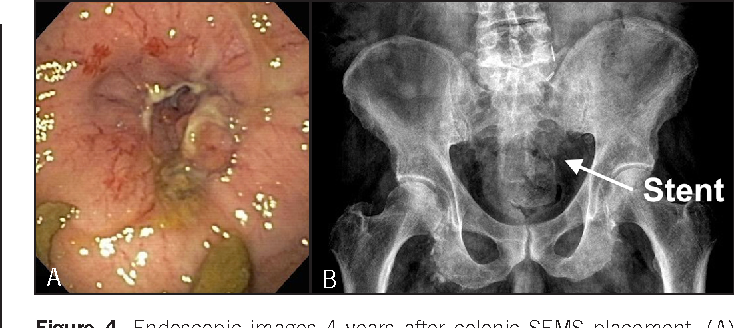


Caption: Figure 4. Endoscopic images 4 years after colonic SEMS placement. (A) Stricture at the site of the previously placed stents in the rectum with tissue hypertrophy and a small ulcer. (B) Although no visible stents were seen during the colonoscopy, a portion of the stents was visualized on abdominal radiograph.
Similarity: 0.65234375


In [ ]:
df = pd.read_json("matching_output.jsonl", lines=True)
ex = df.sample(1).iloc[0]

from IPython.display import Image, display
display(Image(filename=f"{IMAGE_ROOT}/{ex.image_name}"))

print("\nCaption:", ex.caption)
print("Similarity:", ex.similarity)


Enter your medical query: tumor

✅ Best Match Found:
Image: b362a19e4c4b1854f7cbe246a19502a56f52c2b5_3-Figure2-1.png
Caption: Figure 2. Abdominal CT image of a rabbit reveals a low-attenuated tumor in the left lobe of the liver (arrow). CT, computed tomography.
Similarity Score: 0.6346435546875


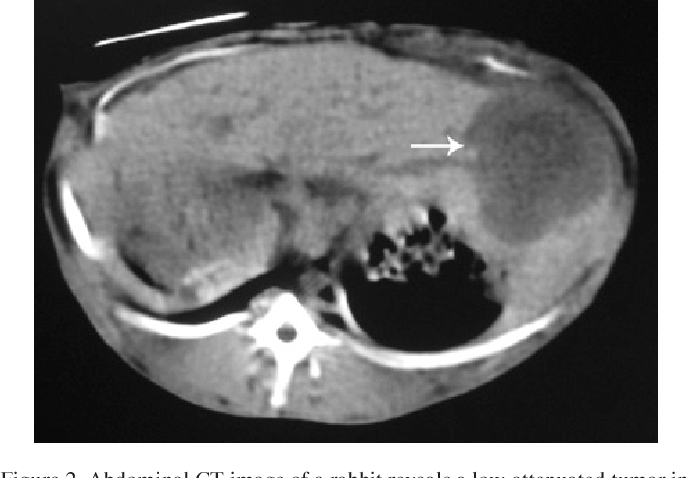

In [ ]:
import pandas as pd
from IPython.display import Image, display

# Load the matching results file
df = pd.read_json("matching_output.jsonl", lines=True)

# Ask the user for text input
query = input("Enter your medical query: ")

# Compute similarity between query and each image caption
df["query_similarity"] = df["caption"].apply(lambda c: text_image_similarity(f"{IMAGE_ROOT}/{df.loc[df['caption'] == c, 'image_name'].values[0]}", query))

# Pick the best match
best = df.sort_values("query_similarity", ascending=False).iloc[0]

# Display result
print("\n✅ Best Match Found:")
print("Image:", best.image_name)
print("Caption:", best.caption)
print("Similarity Score:", best.query_similarity)

# Show image
display(Image(filename=f"{IMAGE_ROOT}/{best.image_name}"))
